In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Patient of interest

In [3]:
def read_file(filename):
    df = pd.read_csv(filename)

    # Split the column into two new columns
    df[['TIMESTAMP', 'HRV']] = df['TIMESTAMP;HRV'].str.split(';', expand=True)

    # Convert TIMESTAMP & HRV to appropriate data types
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])  # Convert TIMESTAMP to datetime
    df['HRV'] = pd.to_numeric(df['HRV'], errors='coerce')  # Convert HRV to numeric

    # Drop the original column
    df.drop(columns=['TIMESTAMP;HRV'], inplace=True)

    # Set TIMESTAMP as the index
    df.set_index('TIMESTAMP', inplace=True)

    return df  # Return the transformed DataFrame

In [4]:
df_patient_hr = read_file('patient_hr_1.csv')

df_patient_hr

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:02.295,631.84
2009-03-04 11:00:02.927,624.02
2009-03-04 11:00:03.551,636.72
2009-03-04 11:00:04.188,625.98
...,...
2009-03-05 08:07:30.918,671.88
2009-03-05 08:07:31.590,669.92
2009-03-05 08:07:32.260,670.90


In [5]:
# check to make sure there are no null values
df_patient_hr.isnull().sum()

HRV    0
dtype: int64

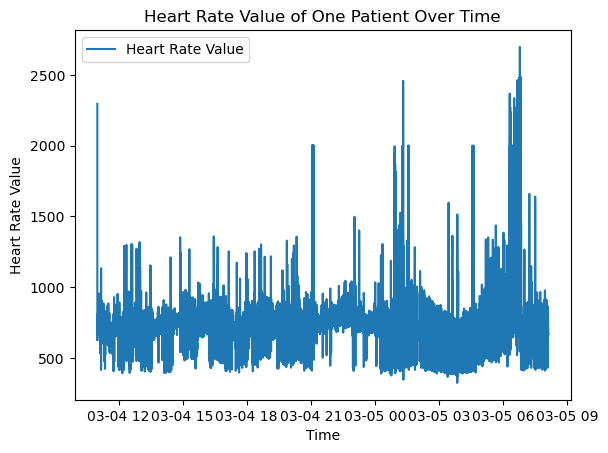

In [6]:
# visualize the time series
plt.plot(df_patient_hr['HRV'], label='Heart Rate Value')
plt.xlabel('Time')
plt.ylabel('Heart Rate Value')
plt.legend()
plt.title('Heart Rate Value of One Patient Over Time')
plt.show();

In [7]:
# getting every 10 samples - downsampling because there are too many samples
df_downsampled = df_patient_hr.iloc[::10]
df_downsampled

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:08.080,674.80
2009-03-04 11:00:15.000,723.63
2009-03-04 11:00:22.142,750.98
2009-03-04 11:00:29.675,730.47
...,...
2009-03-05 08:07:03.508,739.26
2009-03-05 08:07:10.701,694.34
2009-03-05 08:07:17.842,684.57


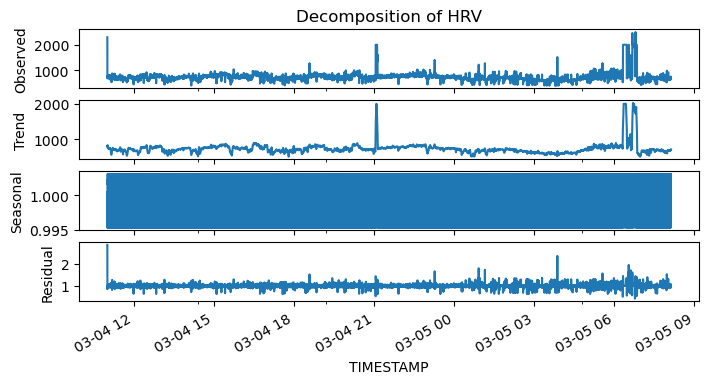

In [8]:
# Checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
# can change model='multiplicative' to see if there's a change in seasonal trend
decomp1 = seasonal_decompose(df_downsampled['HRV'], period=10, model='multiplicative', extrapolate_trend='freq')
# decomp2 = seasonal_decompose(data['Close'], period=5, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

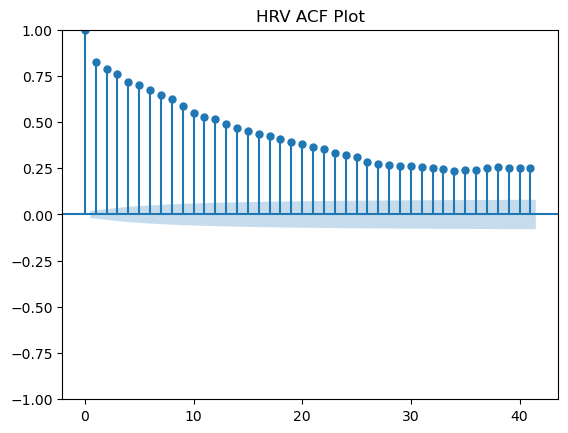

In [9]:
# Autocorrelation Function
# This is used to determine the appropriate lag

# use the original data
series = df_downsampled['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();
# Looks like even up to a lag of 10 could provide significant information about the ensuing years

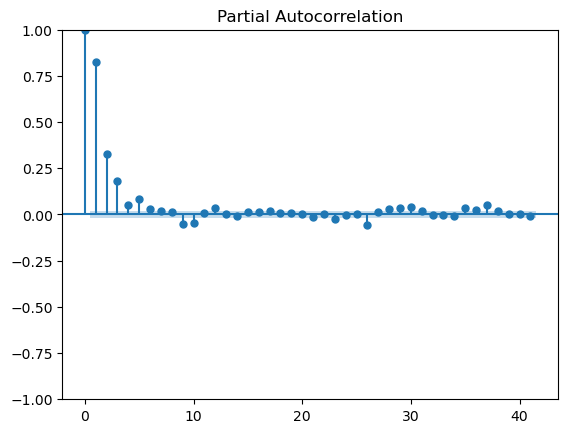

In [10]:
# plot partial autocorrelation function (PACF)
# PACF drops faster, therefore AR model should be better?
plot_pacf(series)
plt.show();

- AR model may be slightly better. This in the partial autocorrelation plot, it doesn't drop immediately.

# Create lag features

In [11]:
for i in range(1, 31):
    df_downsampled[f'Lag {i}'] = df_downsampled['HRV'].shift(i)

df_downsampled = df_downsampled.dropna()

df_downsampled.head()

,HRV,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 21,Lag 22,Lag 23,Lag 24,Lag 25,Lag 26,Lag 27,Lag 28,Lag 29,Lag 30
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2009-03-04 11:03:43.219,666.02,705.08,690.43,730.47,713.87,726.56,778.32,687.50,752.93,715.82,...,771.48,784.18,758.79,775.39,752.93,730.47,750.98,723.63,674.80,2294.92
2009-03-04 11:03:50.195,726.56,666.02,705.08,690.43,730.47,713.87,726.56,778.32,687.50,752.93,...,757.81,771.48,784.18,758.79,775.39,752.93,730.47,750.98,723.63,674.80
2009-03-04 11:03:57.429,734.38,726.56,666.02,705.08,690.43,730.47,713.87,726.56,778.32,687.50,...,737.30,757.81,771.48,784.18,758.79,775.39,752.93,730.47,750.98,723.63
2009-03-04 11:04:04.751,751.95,734.38,726.56,666.02,705.08,690.43,730.47,713.87,726.56,778.32,...,772.46,737.30,757.81,771.48,784.18,758.79,775.39,752.93,730.47,750.98
2009-03-04 11:04:12.098,711.91,751.95,734.38,726.56,666.02,705.08,690.43,730.47,713.87,726.56,...,755.86,772.46,737.30,757.81,771.48,784.18,758.79,775.39,752.93,730.47


# Split data into training and testing set

In [12]:
# Split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
# Take instead the first 80% for the training, then we'll see if the first 80% of MLB history can be used to predict the next 20%
train_size = int(.8 * len(df_downsampled))
train_data = df_downsampled[:train_size]
test_data = df_downsampled[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

# AR Model

In [ ]:
# Define a range of lags to test
lag_values = range(1, 51)  # Testing lags from 1 to 50
mae_scores = []

# Loop through different lag values
for lag in lag_values:
    ar_model = AutoReg(y_train, lags=lag, trend='n')  # Fit AR model with different lags
    ar_results = ar_model.fit()
    
    # Make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # Compute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# Plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

In [ ]:
# Define a range of lags to test
lag_values = range(1, 51)  # Testing lags from 1 to 50
rmse_scores = []

# Loop through different lag values
for lag in lag_values:
    ar_model = AutoReg(y_train, lags=lag, trend='n')  # Fit AR model with different lags
    ar_results = ar_model.fit()
    
    # Make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
     
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)

# Plot RMSE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

## Manually

In [28]:
X_train = train_data.drop(columns=["HRV"])
X_train = np.column_stack((np.ones(len(X_train)), X_train))

# Fit the model using OLS
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
print("Model coefficients:", w)

# Initialize predictions
y_pred = []
last_vals = np.array(train_data['HRV'].iloc[-30:].values[::-1])

# Add constant term to last_vals for prediction
last_vals_with_const = np.concatenate([[1], last_vals])

for i in range(len(y_test)):
    # Predict next value
    next_val = np.dot(last_vals_with_const, w)
    y_pred.append(next_val)
    
    # Update last_vals
    last_vals = np.roll(last_vals, -1)
    last_vals[-1] = next_val
    last_vals_with_const = np.concatenate([[1], last_vals])

Model coefficients: [[ 4.26047015e+01]
 [ 4.59271592e-01]
 [ 2.00395909e-01]
 [ 1.14231518e-01]
 [ 7.34610702e-02]
 [ 3.91684186e-02]
 [ 3.53870985e-02]
 [-1.56770773e-02]
 [ 2.18840705e-02]
 [-6.04410929e-03]
 [-3.02096821e-02]
 [-4.33190629e-02]
 [-4.52781937e-03]
 [ 4.61253949e-03]
 [-4.12670766e-02]
 [ 2.52875068e-02]
 [ 1.57790627e-02]
 [ 1.54142073e-02]
 [ 3.56349188e-02]
 [ 3.98207189e-03]
 [ 1.07138493e-02]
 [-1.90373111e-02]
 [ 1.95098095e-02]
 [-1.02022149e-02]
 [-7.34023933e-04]
 [ 1.21829015e-02]
 [ 1.31194134e-02]
 [-1.54952888e-02]
 [-2.09331818e-03]
 [ 8.64126319e-04]
 [ 2.71054042e-02]]


In [30]:
# Put predictions into a data frame for plotting purposes
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
pred_data.set_index('Time', inplace=True)
pred_data.head()

,pred HRV
Time,
2009-03-05 03:50:21.549,[570.0723111057259]
2009-03-05 03:50:27.199,[550.6429483460447]
2009-03-05 03:50:32.911,[511.20039596268396]
2009-03-05 03:50:38.619,[601.35490651264]
2009-03-05 03:50:44.221,[645.7708295672445]


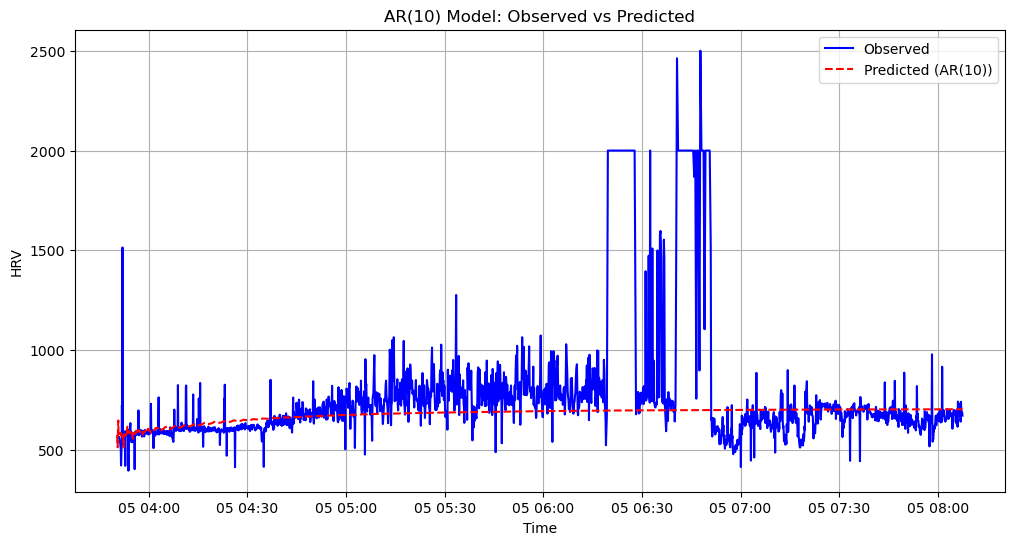

In [31]:
# Plot observed versus predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (AR(10))')
plt.legend()
plt.title('AR(10) Model: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

In [32]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 101.06
Root Mean Squared Error: 239.16


## Using Package

In [23]:
# Using statsmodels AutoReg function
ar_model = AutoReg(y_train, lags=30, trend='c') # the default is to add an intercept (or, trend='c'), 
# using trend='n' is more in line with traditional AR(p) models, but may result in a nonstationary model
ar_results = ar_model.fit()
ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 8574
Model:                    AutoReg(30)   Log Likelihood              -45868.318
Method:               Conditional MLE   S.D. of innovations             51.912
Date:                Thu, 10 Apr 2025   AIC                          91800.636
Time:                        18:42:21   BIC                          92026.331
Sample:                            30   HQIC                         91877.634
                                 8574                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.3048      5.429      7.792      0.000      31.663      52.946
y.L1           0.4593      0.011     42.477      0.000       0.438       0.480
y.L2           0.2000      0.012     16.804      0.000       0.177       0.223
y.L3           0.1146      0.012      9.463      0.000       0.091       0.138
y.L4           0.0737      0.012      6.060      0.000       0.050       0.098
y.L5           0.0391      0.012      3.203      0.001       0.015       0.063
y.L6           0.0358      0.012      2.929      0.003       0.012       0.060
y.L7          -0.0160      0.012     -1.308      0.191      -0.040       0.008
y.L8           0.0222      0.012      1.817      0.069      -0.002       0.046
y.L9          -0.0065      0.012     -0.531      0.595      -0.030       0.017
y.L10         -0.0296      0.012     -2.426      0.015      -0.054      -0.006
y.L11         -0.0443      0.012     -3.624      0.000      -0.068      -0.020
y.L12         -0.0051      0.012     -0.415      0.678      -0.029       0.019
y.L13          0.0044      0.012      0.360      0.719      -0.020       0.028
y.L14         -0.0418      0.012     -3.424      0.001      -0.066      -0.018
y.L15          0.0260      0.012      2.124      0.034       0.002       0.050
y.L16          0.0161      0.012      1.315      0.188      -0.008       0.040
y.L17          0.0158      0.012      1.293      0.196      -0.008       0.040
y.L18          0.0360      0.012      2.944      0.003       0.012       0.060
y.L19          0.0042      0.012      0.346      0.730      -0.020       0.028
y.L20          0.0107      0.012      0.872      0.383      -0.013       0.035
y.L21         -0.0188      0.012     -1.542      0.123      -0.043       0.005
y.L22          0.0192      0.012      1.569      0.117      -0.005       0.043
y.L23         -0.0105      0.012     -0.857      0.392      -0.034       0.013
y.L24         -0.0009      0.012     -0.077      0.939      -0.025       0.023
y.L25          0.0117      0.012      0.954      0.340      -0.012       0.036
y.L26          0.0128      0.012      1.052      0.293      -0.011       0.037
y.L27         -0.0163      0.012     -1.335      0.182      -0.040       0.008
y.L28         -0.0030      0.012     -0.246      0.806      -0.027       0.021
y.L29         -0.0023      0.012     -0.194      0.846      -0.026       0.021
y.L30          0.0335      0.011      3.095      0.002       0.012       0.055
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0167           -0.0000j            1.0167           -0.0000
AR.2             1.0612           -0.2036j            1.0805           -0.0302
AR.3             1.0612           +0.2036j            1.0805            0.0302
AR

In [24]:
print(ar_results.params)
print(abs(ar_results.roots))

[ 4.23048235e+01  4.59282910e-01  1.99950665e-01  1.14565282e-01
  7.37476063e-02  3.90945251e-02  3.57666725e-02 -1.59769911e-02
  2.21976427e-02 -6.48668307e-03 -2.96331989e-02 -4.42805464e-02
 -5.07452979e-03  4.40232844e-03 -4.18401215e-02  2.59683765e-02
  1.60841666e-02  1.58041833e-02  3.59784513e-02  4.22573987e-03
  1.06520212e-02 -1.88283413e-02  1.91668632e-02 -1.04718477e-02
 -9.42685709e-04  1.16543908e-02  1.28421574e-02 -1.62686845e-02
 -2.97618638e-03 -2.31223714e-03  3.35218573e-02]
[1.01665989 1.0805202  1.0805202  1.13189461 1.13189461 1.134345
 1.134345   1.12540882 1.12540882 1.10765396 1.10765396 1.1177556
 1.1177556  1.10266758 1.10266758 1.1162478  1.1162478  1.100771
 1.11513337 1.11513337 1.15498947 1.15498947 1.11294032 1.11294032
 1.1431971  1.1431971  1.15374013 1.15374013 1.14773934 1.14773934]


For the stationarity assumption to be met, the absolute value of the roots should be greater than 1. In general, based on the roots from above, all of the values are greater than 1. Therefore, it can be said that the stationarity assumption is met.

In [25]:
# the predictions
ar_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ar_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
2009-03-05 03:50:21.549,569.937082
2009-03-05 03:50:27.199,572.402797
2009-03-05 03:50:32.911,567.953006
2009-03-05 03:50:38.619,572.551440
2009-03-05 03:50:44.221,584.010498


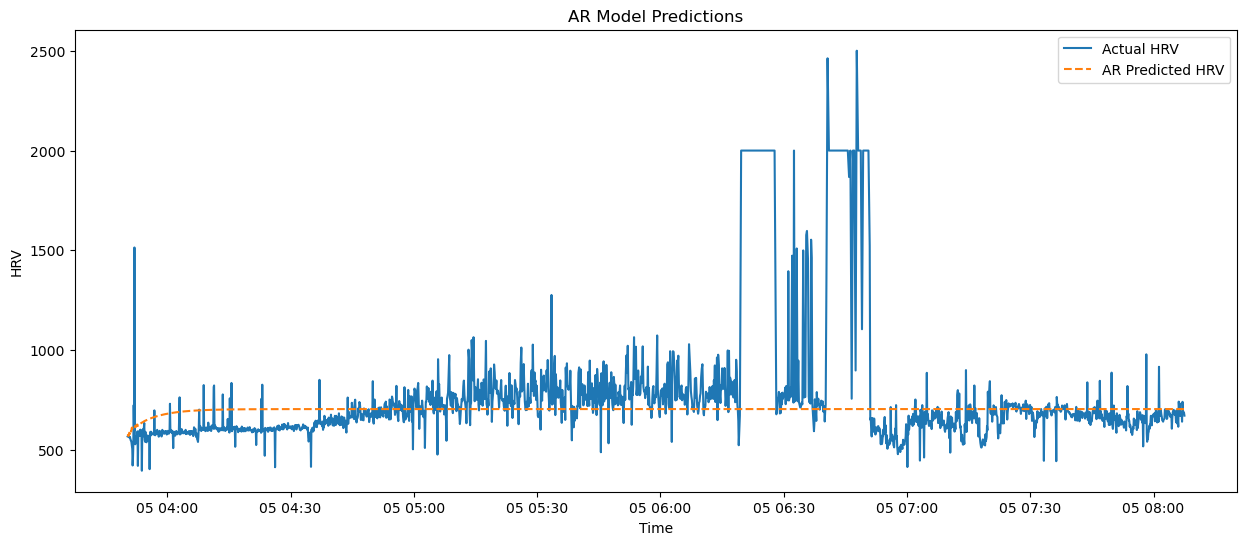

In [26]:
# make the plot
plt.figure(figsize=(15, 6))

plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'AR Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('AR Model Predictions')
plt.show();

In [27]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 112.71
Root Mean Squared Error: 240.47


# MA model

In [ ]:
# Define a range of orders to test
o_values = range(1, 12)  # Testing orders from 1 to 10
mae_scores = []

# Loop through different order values
for o in o_values:
    ma_model = ARIMA(y_train, order=(0,0,o), trend='n')
    ma_results = ma_model.fit()
    
    # Make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # Compute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# Plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(o_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

In [ ]:
# Define a range of orders to test
o_values = range(1, 12)  # Testing orders from 1 to 10
rmse_scores = []

# Loop through different order values
for o in o_values:
    ma_model = ARIMA(y_train, order=(0,0,o), trend='n')
    ma_results = ma_model.fit()
    
    # Make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)


# Plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(o_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

## Manually

In [ ]:
import numpy as np
import pandas as pd
from scipy import optimize, stats
import matplotlib.pyplot as plt

# calculate the error terms (residuals)
def ma_errors(params, y, q):
    """
    Calculate residuals for MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    intercept = params[0]  
    theta = params[1:]  
    n = len(y)
    errors = np.zeros(n)
    
    # initialize past errors
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
        # Reverse the order of theta coefficients
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # Shift right instead of left
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
        
    return errors

# calculate the log-likelihood for MA(q) model
def ma_log_likelihood(params, y, q):
    """
    Calculate the log-likelihood for MA(10) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    intercept = params[0]
    theta = params[1:]
    n = len(y)
    errors = np.zeros(n)
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
       # Reverse the order of theta coefficients
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # Shift right instead of left
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
    
    # calculate log-likelihood (assuming errors are normally distributed)
    sigma2 = np.var(errors)  # Estimate of error variance
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(errors**2) / sigma2
    return -log_likelihood  # Return negative log-likelihood for minimization

# fit MA model using MLE
def fit_ma_mle(y_train, q):
    """
    Fit MA(q) model with intercept using Maximum Likelihood Estimation
    """
    # Initial guess for parameters (intercept and theta parameters)
    initial_intercept = np.mean(y_train)
    initial_theta = np.zeros(q)
    initial_params = np.concatenate(([initial_intercept], initial_theta))
    
    # Use optimization to find the best parameters
    result = optimize.minimize(ma_log_likelihood, initial_params, args=(y_train, q,), 
                             method='L-BFGS-B')
    return result.x

# predict using MA model
def predict_ma(params, y_test_len, training_errors, q):
    """
    Make predictions using MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters
    y_test_len: number of steps to predict
    training_errors: last q error terms from training data
    """
    intercept = params[0]
    theta = params[1:]
    
    # Initialize predictions array
    predictions = np.zeros(y_test_len)
    # Start with last q error terms from training
    past_errors = np.array(training_errors[:q])
    
    for t in range(y_test_len):
        # Reverse the order of theta coefficients
        predictions[t] = intercept + np.sum(theta * past_errors)
        new_error = 0
        # Shift right instead of left
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = new_error
        
    return predictions

# fit MA(q) and make predictions
def run_ma_model_mle(train_data, test_data, q):
    # Convert Series to numpy arrays
    y_train = np.array(train_data['HRV'])
    
    # fit MA(q) model with intercept using MLE
    params = fit_ma_mle(y_train, q)
    intercept = params[0]
    theta = params[1:]
    
    # print coefficients
    print("Coefficients:")
    print(f"Intercept: {intercept:.6f}")
    for i, coef in enumerate(theta):
        print(f"MA({i+1}): {coef:.6f}")
    
    # calculate errors from training data
    training_errors = ma_errors(params, y_train, q)
    
    # make predictions
    y_pred = predict_ma(params, len(test_data), training_errors, q)
    
    # put predictions into dataframe format
    pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
    pred_data.set_index('Time', inplace=True)
    
    return pred_data, params

In [ ]:
pred_data, theta = run_ma_model_mle(train_data, test_data, 10)
pred_data.head()

Coefficients for the manual implementation is reversed compared to the package implementation?

In [ ]:
# Plot observed versus predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (MA(10))')
plt.legend()
plt.title('MA(10) Model with Intercept: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

In [ ]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

## Using Package

In [ ]:
ma_model = ARIMA(y_train, order=(0, 0, 10))
ma_results = ma_model.fit()

#summary of the model
ma_results.summary()

In [ ]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
ma_pred = ma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ma_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

In [ ]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'MA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('MA Model Predictions')
plt.show();

In [ ]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

# Remove code below?

# ARIMA Model

## Manually

In [ ]:
import numpy as np
import pandas as pd
from scipy import optimize, stats
import matplotlib.pyplot as plt

# Function to calculate the error terms (residuals)
def arima_errors(params, y, p, q):
    """
    Calculate residuals for ARIMA(p,0,q) model with intercept
    params: 
        - first element is intercept
        - next p elements are phi parameters (AR coefficients)
        - last q elements are theta parameters (MA coefficients)
    y: observed values
    """
    intercept = params[0]         # First parameter is the intercept
    phi = params[1:(p+1)]            # Next 10 parameters are AR coefficients
    theta = params[(p+1):]           # Last 10 parameters are MA coefficients
    n = len(y)
    errors = np.zeros(n)
    
    # Initialize past observations and past errors
    # (we don't know true past values, so we start with zeros)
    past_y = np.zeros(p)          # For AR terms (p=10)
    past_errors = np.zeros(q)     # For MA terms (q=10)
    
    # Calculate errors
    for t in range(n):
        # Predict using intercept plus AR terms plus MA terms
        ar_component = np.sum(phi * past_y)
        ma_component = np.sum(theta * past_errors)
        prediction = intercept + ar_component + ma_component
        
        # Calculate current error
        errors[t] = y[t] - prediction
        
        # Update past observations by shifting and adding new observation
        past_y = np.roll(past_y, -1)
        past_y[-1] = y[t]
        
        # Update past errors by shifting and adding new error
        past_errors = np.roll(past_errors, -1)
        past_errors[-1] = errors[t]
        
    return errors

# Function to calculate the log-likelihood for ARIMA(p,0,q) model
def arima_log_likelihood(params, y):
    """
    Calculate the log-likelihood for ARIMA(p,0,q) model with intercept
    params: 
        - first element is intercept
        - next p elements are phi parameters (AR coefficients)
        - last q elements are theta parameters (MA coefficients)
    y: observed values
    """
    errors = arima_errors(params, y)
    
    # Calculate log-likelihood (assuming errors are normally distributed)
    n = len(errors)
    sigma2 = np.var(errors)  # Estimate of error variance
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(errors**2) / sigma2
    return -log_likelihood  # Return negative log-likelihood for minimization

# Fit ARIMA(p,0,q) model using MLE
def fit_arima_mle(y_train, p, q):
    """
    Fit ARIMA(p,0,q) model with intercept using Maximum Likelihood Estimation
    """
    # Initial guess for parameters (intercept, phi parameters, and theta parameters)
    initial_intercept = np.mean(y_train)
    initial_phi = np.zeros(p)      # Initialize AR coefficients to zero
    initial_theta = np.zeros(q)    # Initialize MA coefficients to zero
    initial_params = np.concatenate(([initial_intercept], initial_phi, initial_theta))
    
    # Use optimization to find the best parameters
    result = optimize.minimize(arima_log_likelihood, initial_params, args=(y_train,), 
                             method='L-BFGS-B')
    return result.x

# Predict using ARIMA(p,0,q) model
def predict_arima(params, y_train, y_test_len, p, q):
    """
    Make predictions using ARIMA(p,0,q) model with intercept
    params: 
        - first element is intercept
        - next p elements are phi parameters (AR coefficients)
        - last q elements are theta parameters (MA coefficients)
    y_train: training data used to initialize the model
    y_test_len: number of steps to predict
    """
    intercept = params[0]
    phi = params[1:(p+1)]
    theta = params[(p+1):]
    
    # Initialize predictions array
    predictions = np.zeros(y_test_len)
    
    # Get the last 10 observations from training data for AR terms
    last_observations = y_train[-(p+1):].copy() if len(y_train) >= p else np.zeros(p)
    
    # Get the last 10 errors from training data for MA terms
    training_errors = arima_errors(params, y_train)
    last_errors = training_errors[-(q+1):].copy() if len(training_errors) >= q else np.zeros(q)
    
    # Make forecasts
    for t in range(y_test_len):
        # Predict using intercept plus AR terms plus MA terms
        ar_component = np.sum(phi * last_observations)
        ma_component = np.sum(theta * last_errors)
        predictions[t] = intercept + ar_component + ma_component
        
        # Update past observations for next forecast
        last_observations = np.roll(last_observations, -1)
        last_observations[-1] = predictions[t]  # Use the predicted value 
        
        # Since we don't know the true error for test data,
        # we assume the error is zero for future predictions
        new_error = 0  
        last_errors = np.roll(last_errors, -1)
        last_errors[-1] = new_error
        
    return predictions

# Main process to fit ARIMA(p,0,q) and make predictions
def run_arima_model_mle(train_data, test_data, p, q):
    # Convert Series to numpy arrays
    y_train = np.array(train_data['HRV'])
    
    # Fit ARIMA(p,0,q) model with intercept using MLE
    params = fit_arima_mle(y_train, p, q)
    intercept = params[0]
    phi = params[1:(p+1)]
    theta = params[(p+1):]
    
    print("Coefficients:")
    print(f"Intercept: {intercept:.6f}")
    for i, coef in enumerate(phi):
        print(f"AR({i+1}): {coef:.6f}")
    for i, coef in enumerate(theta):
        print(f"MA({i+1}): {coef:.6f}")
    
    # Make predictions
    y_pred = predict_arima(params, y_train, len(test_data), p, q)
    
    # Put predictions into a data frame for plotting purposes
    pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
    pred_data.set_index('Time', inplace=True)
    
    return pred_data, params

In [ ]:
pred_data, params = run_arima_model_mle(train_data, test_data, 10, 10)
pred_data.head()

In [ ]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

## Using Package

In [ ]:
arima_model = ARIMA(y_train, order=(10, 0, 10))
arima_results = arima_model.fit()

#summary of the model
arima_results.summary()

In [ ]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
arima_pred = arima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': arima_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

In [ ]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'ARIMA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show();

In [ ]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

The mean absolute error and root mean squared error for ARIMA (using both AR and MA together) is better than when just using AR.